# 0. Imports

## 0.1 Libraries

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

import shap

c:\Users\Yael Dahari\Tabular-Data\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2. Model and data from part 1

In [2]:
from pickle import load
with open("../Part_1/part_1_model.pkl", "rb") as f:
    linear_reg = load(f)

df_train = pd.read_csv('../Part_1/data/processed_train_data.csv',index_col='id')
df_test = pd.read_csv('../Part_1/data/processed_test_data.csv',index_col='id')

In [3]:
df_train.head()

,model_year,milage,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,...,int_col_Brown,int_col_Ebony,int_col_Global Black,int_col_Gray,int_col_Jet Black,int_col_Orange,int_col_Red,int_col_White,int_col_other,price
id,,,,,,,,,,,,,,,,,,,,,
0,2007,213000,False,True,172.0,1.6,4.0,True,False,False,...,False,False,False,True,False,False,False,False,False,4200
1,2002,143250,True,True,252.0,3.9,8.0,True,False,False,...,False,False,False,False,False,False,False,False,False,4999
2,2002,136731,False,True,320.0,5.3,8.0,True,False,False,...,False,False,False,True,False,False,False,False,False,13900
3,2017,19500,False,True,420.0,5.0,8.0,False,False,True,...,False,False,False,False,False,False,False,False,False,45000
4,2021,7388,False,True,208.0,2.0,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,97500


In [4]:
df_test.head()

,model_year,milage,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,...,int_col_Brown,int_col_Ebony,int_col_Global Black,int_col_Gray,int_col_Jet Black,int_col_Orange,int_col_Red,int_col_White,int_col_other,price
id,,,,,,,,,,,,,,,,,,,,,
150826,2021,52253,True,False,343.0,2.5,6.0,True,False,False,...,False,False,False,False,False,False,False,False,True,25215
150827,2006,127500,False,True,208.0,2.0,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,9750
150828,2005,16300,False,True,239.0,4.6,8.0,True,False,False,...,False,False,False,True,False,False,False,False,False,19950
150829,2012,13133,False,True,333.0,3.0,6.0,True,False,False,...,False,False,False,False,False,False,False,False,False,13999
150830,2011,106000,True,True,300.0,3.0,6.0,False,False,True,...,False,False,False,False,False,False,False,False,False,6900


In [5]:
def train_score_model (df_train, df_test):
	X_train = df_train.drop(columns='price')
	y_train = df_train['price']
	X_test = df_test.drop(columns='price')
	y_test = df_test['price']
	
	linear_reg = LinearRegression()
	linear_reg.fit(X_train, y_train)
	y_pred = linear_reg.predict(X_test)
	
	r2 = r2_score(y_test, y_pred)
	
	return r2

# 1. Error Analysis

First, we wanted to confirm that the errors of our model do not result from a prr distribution od the data in the train and test sets.

The train set data is painted colored blue and the test set data is colored orange.

We can see that the distributions are quite similar, most of the graphs have a red shade - because the train and test mostly overlap.

In additon, we added a Two-Sample KS test for a quantifiable measure.

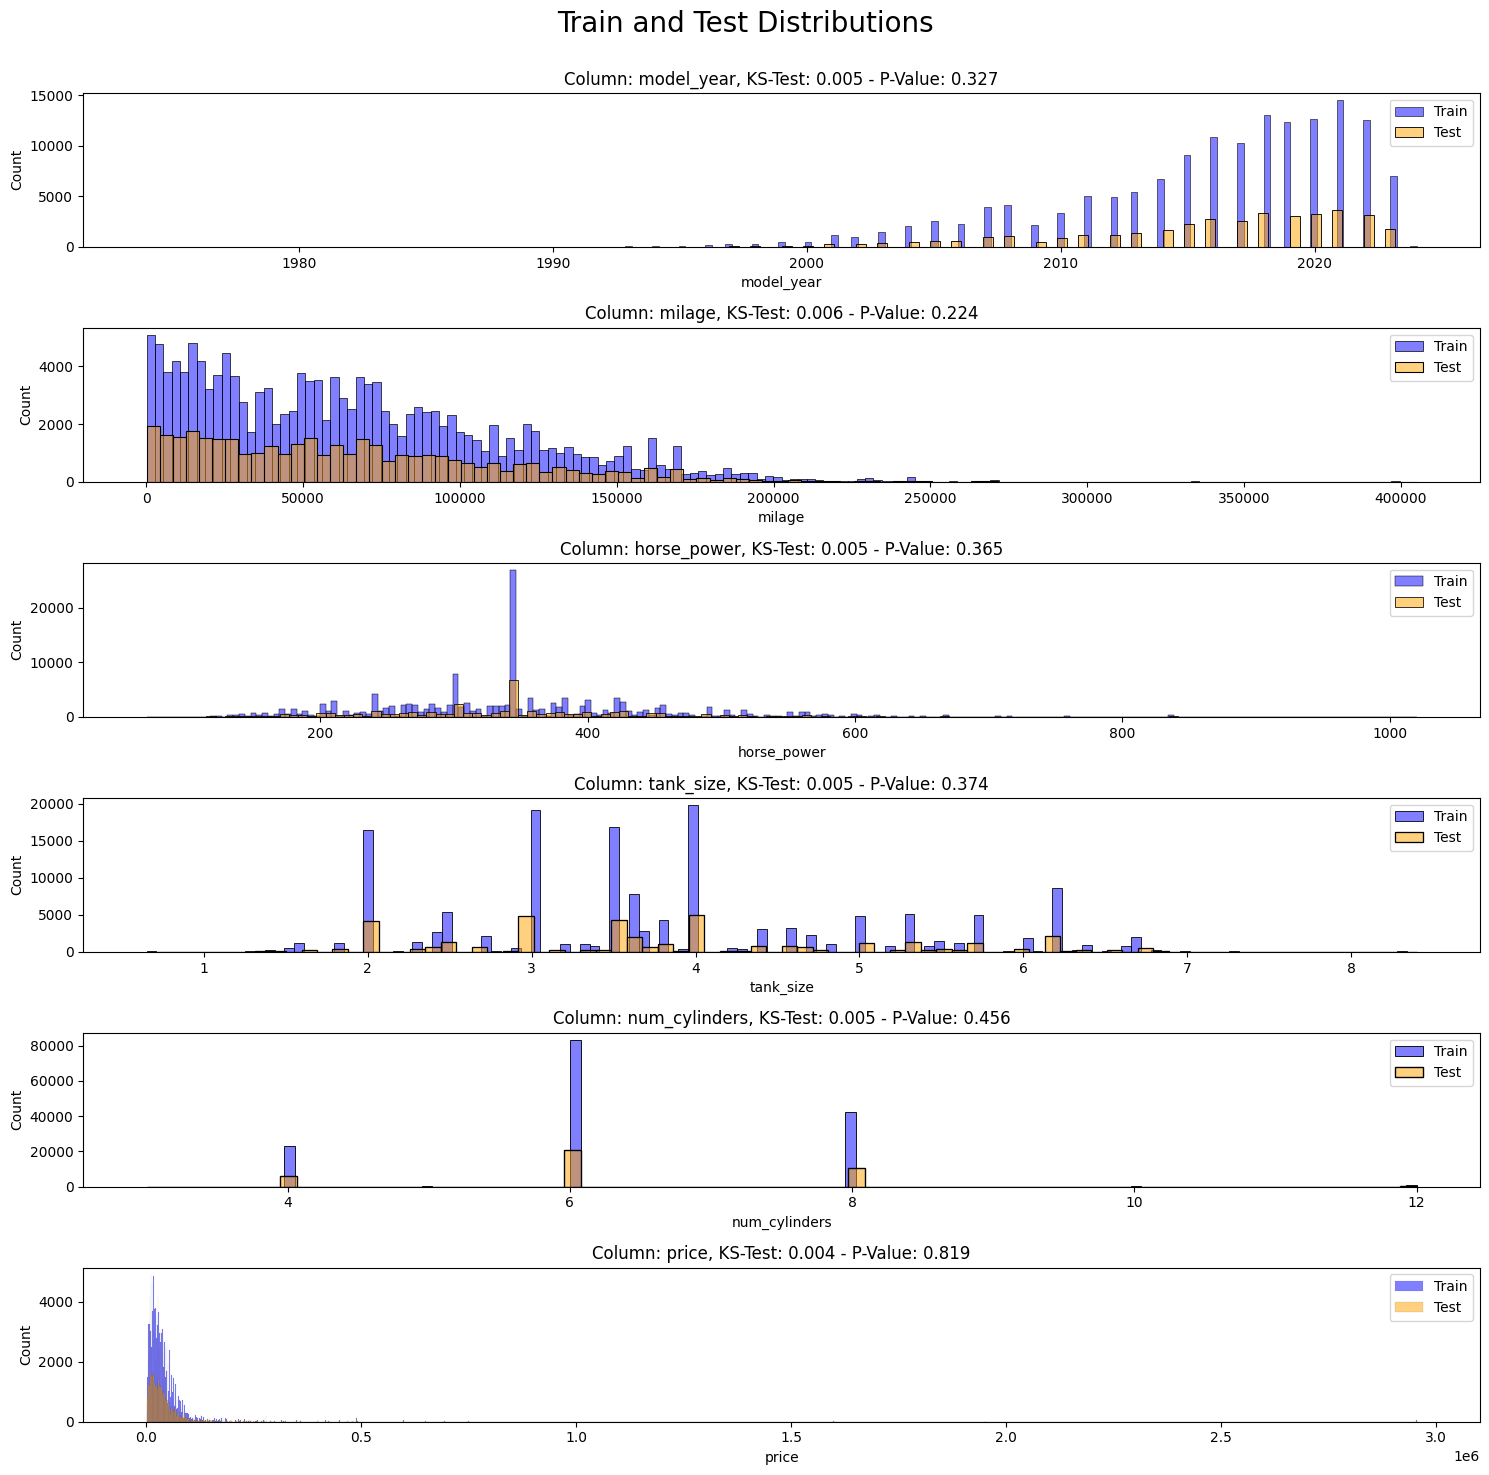

In [6]:
columns_to_hist = ['model_year', 'milage', 'horse_power', 'tank_size', 'num_cylinders', 'price']

fig, axes = plt.subplots(6, 1, figsize=(15, 15))
for i, column in enumerate(columns_to_hist):
    sns.histplot(df_train[column], ax=axes[i], color='blue', label='Train', alpha=0.5)
    sns.histplot(df_test[column], ax=axes[i], color='orange', label='Test', alpha=0.5)
    res,pval = ks_2samp(df_train[column],df_test[column])
    axes[i].set_title(f'Column: {column}, KS-Test: {round(res, 3)} - P-Value: {round(pval, 3)}')
    axes[i].legend()
fig.suptitle('Train and Test Distributions\n', fontsize=20)
plt.tight_layout()
plt.show()

## 1.1 Explainability changes

To improve the model explainability we would like to transform attributes differently than we did in the previous exercise.

Doing this would allow us to analyse the model errors better, as there would be less features that would clutter our view of the importance of each feature.

This is based on our first attempt at error analysis. We noticed how difficult it was for us to interpret the results from the SHAP graphs of the previous exercise.

In [7]:
org_df_train = pd.read_csv('../Part_1/data/raw_train_data.csv',index_col='id')
org_df_test = pd.read_csv('../Part_1/data/raw_test_data.csv',index_col='id')

### 1.1.1 Color

In the previous exercise we decided to discard of colors which were not of the top 12 most common colors.
This time we do not lose data by grouping defferent shades to their "origin" color.

In exchange we minimize the variety of our data column - under the premis that the differences in shade are not meaningful for the prediction of the car price.

In [8]:
colors_drop = [col for col in df_train if col.startswith(("int", "ext"))]

# brands_drop = [col for col in df_train if col.startswith(("brand"))]

In [9]:
df_train = df_train.drop(columns=colors_drop)
df_test = df_test.drop(columns=colors_drop)

# df_train = df_train.drop(columns=brands_drop)
# df_test = df_test.drop(columns=brands_drop)

In [10]:
df_train = pd.concat([df_train,org_df_train[['int_col', 'ext_col']]],axis=1)
df_test = pd.concat([df_test,org_df_test[['int_col', 'ext_col']]],axis=1)

Colors that fall into "Other":

'oyster w/contrast', 'ceramic', 'gideon',
'sport', '–', 'designo magno matte',
'dark sapphire', 'custom color', 'tempest', 'lunar rock',
'nightfall mica', 'granite', 'Pink', 'c / c', 'yulong',
'go mango!', 'grigio nimbus', 'metallic'

In [11]:
def categorize_color(color):
    color = color.lower()
    # Black group
    if any(x in color for x in [
        'black', 'obsidian', 'raven', 'onyx', 'ebony', 'nero', 'blk',
        'graphite', 'charcoal', 'dark ash', 'anthracite', 'caviar', 
        'dark matter', 'magnetic', 'beluga', 'dark galvanized']):
        return 'Black'
    # White group
    elif any(x in color for x in [
        'white', 'pearl', 'ivory', 'frost', 'platinum', 'ice', 'cloud',
        'chalk', 'bianco', 'glacier', 'linen', 'very light cashmere', 
        'parchment', 'parchment.']):
        return 'White'
    # Blue group
    elif any(x in color for x in [
        'blue', 'navy', 'aqua', 'teal', 'stormy', 'blu', 'eleos']):
        return 'Blue'
    # Red group
    elif any(x in color for x in [
        'red', 'ruby', 'garnet', 'hotspur', 'pimento', 'rosso', 
        'scarlet', 'mars', 'corsa', 'chateau']):
        return 'Red'
    # Silver/Gray group
    elif any(x in color for x in [
        'silver', 'gray', 'grey', 'steel', 'medium pewter', 'slate', 
        'boulder', 'porpoise', 'light slate', 'tungsten', 'gun metallic', 
        'medium stone', 'portland', 'mesa', 'ash']):
        return 'Silver_Gray'
    # Green group
    elif any(x in color for x in [
        'green', 'verde', 'moss', 'deep cypress']):
        return 'Green'
    # Yellow/Orange group
    elif any(x in color for x in [
        'yellow', 'gold', 'orange', 'amber', 'arancio', 'hellayella', 
        'sunset drift', 'sandstone', 'tension']):
        return 'Yellow_Orange'
    # Brown group
    elif any(x in color for x in [
        'brown', 'beige', 'tan', 'mocha', 'brandy', 'chestnut', 
        'espresso', 'roast', 'dark auburn', 'aragon', 'bronze', 
        'dune', 'maroon', 'walnut', 'camel', 'caramel', 'macchiato', 
        'medium light camel', 'shale', 'cappuccino', 'tupelo']):
        return 'Brown'
    # Purple group
    elif any(x in color for x in ['purple', 'plum', 'ametrin', 'orchid', 'pink']):
        return 'Purple_Pink'
    # Default for unclassified entries
    else:
        return 'Other'

In [12]:
df_train['int_col'] = df_train['int_col'].apply(categorize_color)
df_train['ext_col'] = df_train['ext_col'].apply(categorize_color)

df_test['int_col'] = df_test['int_col'].apply(categorize_color)
df_test['ext_col'] = df_test['ext_col'].apply(categorize_color)

Converting the new int_color, ext_color to One-Hot features for the Linear Regression model.

We combine train and test data to ensure consistent encoding.

In [13]:
df_combined = pd.concat([df_train, df_test])

# Convert categorical columns to numeric using one-hot encoding
df_combined = pd.get_dummies(df_combined, columns=['int_col', 'ext_col'], drop_first=True)

# boolean_columns = df_combined.select_dtypes(include=['bool']).columns
# df_combined[boolean_columns] = df_combined[boolean_columns].astype(int)

# Split the combined data back into train and test sets
df_train = df_combined.iloc[:len(df_train)]
df_test = df_combined.iloc[len(df_train):]

In [14]:
df_train.head()

,model_year,milage,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,...,int_col_Yellow_Orange,ext_col_Blue,ext_col_Brown,ext_col_Green,ext_col_Other,ext_col_Purple_Pink,ext_col_Red,ext_col_Silver_Gray,ext_col_White,ext_col_Yellow_Orange
id,,,,,,,,,,,,,,,,,,,,,
0,2007,213000,False,True,172.0,1.6,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2002,143250,True,True,252.0,3.9,8.0,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2002,136731,False,True,320.0,5.3,8.0,True,False,False,...,False,True,False,False,False,False,False,False,False,False
3,2017,19500,False,True,420.0,5.0,8.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,2021,7388,False,True,208.0,2.0,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


## Testing the changes

We can see that the transformation of the color columns had almost no affect on the R2 score, meaning our previous thing did not do good.

In [15]:
print(f'R2 Score before convering the color columns: {round(0.10637623834770804, 4)}')

score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after convering the color columns: {round(score_after_change, 4)}')

R2 Score before convering the color columns: 0.1064
R2 Score after convering the color columns: 0.105


### 1.1.2 Horse power 

In [16]:
df_train_transformed = pd.read_csv('../Part_1/data/transformed_train_data.csv',index_col='id')
df_test_transformed = pd.read_csv('../Part_1/data/transformed_test_data.csv',index_col='id')

Replacing the data for Not Supported, Nan and - in fuel type to random values and checking if it changes the r squared

In [17]:
# Capture the original column order of df_train and df_test
original_train_columns = df_train.columns
original_test_columns = df_test.columns

min_hp = df_train['horse_power'].min()
max_hp = df_train['horse_power'].max()

# Check the value of 'horse_power' in the original dataframe and update the one-hot encoded columns in df
def replace_invalid_horse_power(row, org_row):
    if pd.isna(org_row['horse_power']):
        new_horse_power = np.random.randint(min_hp, max_hp)
        row['horse_power'] = new_horse_power
    return row

# Apply the function to the 'horse_power' column in both train and test dataframes
df_train = df_train.apply(lambda row: replace_invalid_horse_power(row, df_train_transformed.loc[row.name]), axis=1)
df_test = df_test.apply(lambda row: replace_invalid_horse_power(row, df_test_transformed.loc[row.name]), axis=1)

# Restore the original column order
df_train = df_train[original_train_columns]
df_test = df_test[original_test_columns]

In [18]:
print(f'R2 Score before replacing fuel type values with random values: {round(score_after_change, 4)}')

score_after_change_ = train_score_model(df_train, df_test)
print(f'R2 Score after replacing fuel type values with random value: {round(score_after_change_, 4)}')

R2 Score before replacing fuel type values with random values: 0.105
R2 Score after replacing fuel type values with random value: 0.105


As we can see, we got about the same R^2 value even with random values imputation. Therefore, we can infer that we need to come up with another way to fill those values. Maybe using KNN.

In [19]:
from sklearn.impute import KNNImputer

df_train_transformed_copy = df_train_transformed.copy()
df_test_transformed_copy = df_test_transformed.copy()

# Apply KNNImputer
imputer = KNNImputer(n_neighbors=3)

# Impute missing values in 'horse_power' for df_train_transformed_copy and df_test_transformed_copy
df_train_transformed_copy['horse_power'] = imputer.fit_transform(df_train_transformed_copy[['horse_power']])
df_test_transformed_copy['horse_power'] = imputer.transform(df_test_transformed_copy[['horse_power']])
 
# Update the one-hot encoded columns in df_train using the imputed 'horse_power' values from org_df_train_copy
def update_horse_power_encoding(row, imputed_horse_power):
    row['horse_power'] = imputed_horse_power
    return row

# Apply the updates to df_train and df_test
df_train = df_train.apply(lambda row: update_horse_power_encoding(row, df_train_transformed_copy.loc[row.name, 'horse_power']), axis=1)
df_test = df_test.apply(lambda row: update_horse_power_encoding(row, df_test_transformed_copy.loc[row.name, 'horse_power']), axis=1)


In [20]:
print(f'R2 Score before replacing fuel type values with KNN-based values: {round(score_after_change, 4)}')

score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after replacing fuel type values with KNN-based value: {round(score_after_change, 4)}')

R2 Score before replacing fuel type values with KNN-based values: 0.105
R2 Score after replacing fuel type values with KNN-based value: 0.105


Didn't see a change, probably because there were only 3% of the data. let's do it on a different attribute (maybe horsepower)

### 1.1.3 Brand

In exercise 1 we decided to turn brands into One-Hot vectors. Since there are many brands, we decided to turn only the 24 most common brand names into binary features, lumping the rest as "Other"

his time we do...

We can see that the model's R2 score went up/down and that the explianability is better/worse...



## ordinal encoder for the brand names 

## 1.2 Data and model changes

Brand transformation - Arbel

remove outlliers && divide the price range into bins, check if there is an equal number of data entries for each price bin. maybe balance if not. Yael

multiple collinearity show features correlation to one another [df.corr()] - decide on a course of action - Arbel

rescale features which are not in a linear relationship with the price - Yael

turn n values into n-1 One-Hot features: trasmission (baseline should be the most frequent value) - Arbel

## Removing Outliers
Study the distributions of the data to remove outliers

In [22]:
df_test.shape

(37707, 57)

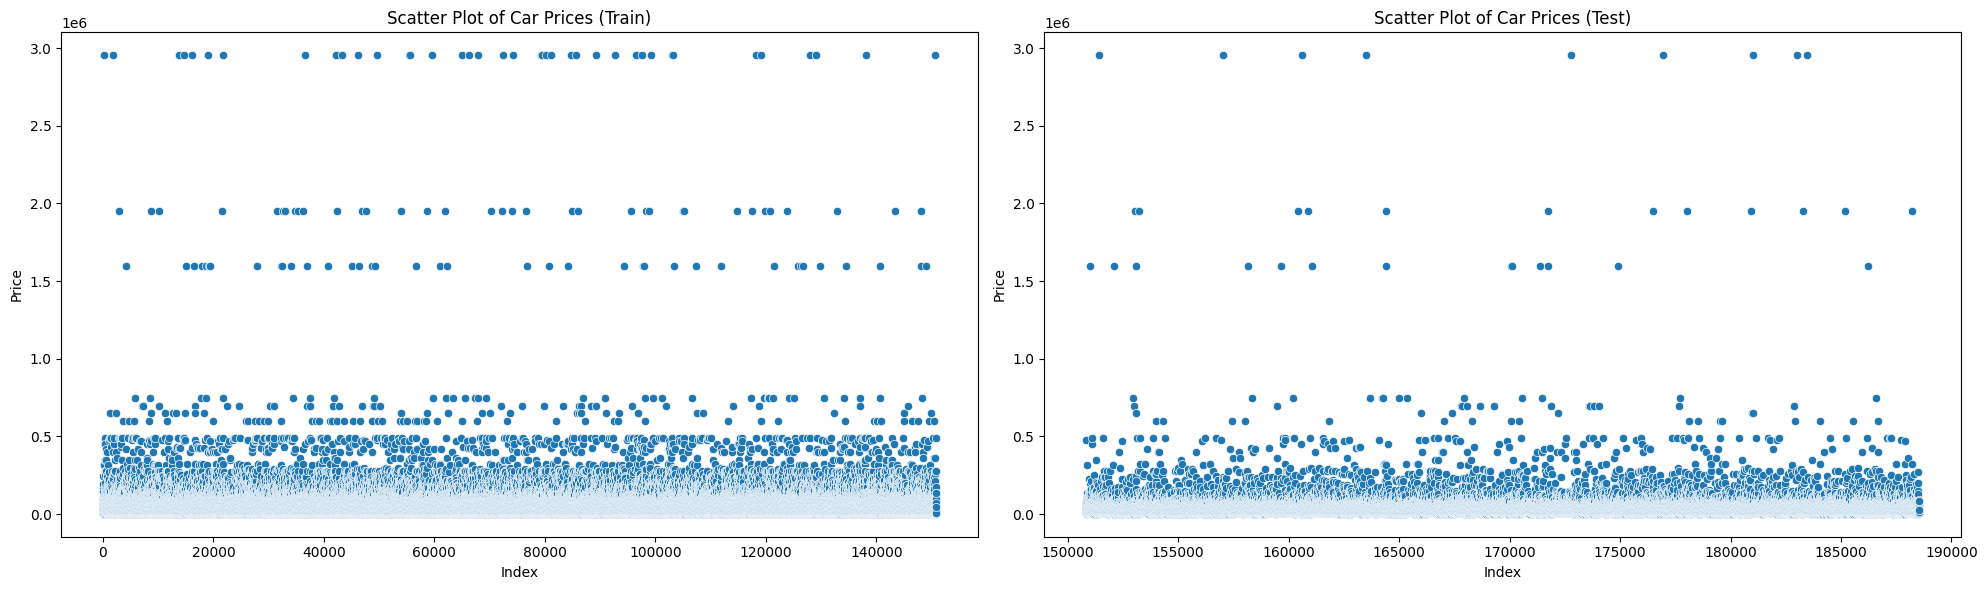

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.scatterplot(data=df_train, x=df_train.index, y='price', ax=axes[0])
axes[0].set_title('Scatter Plot of Car Prices (Train)')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Price')

sns.scatterplot(data=df_test, x=df_test.index, y='price', ax=axes[1])
axes[1].set_title('Scatter Plot of Car Prices (Test)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Price')

plt.tight_layout()
plt.show()

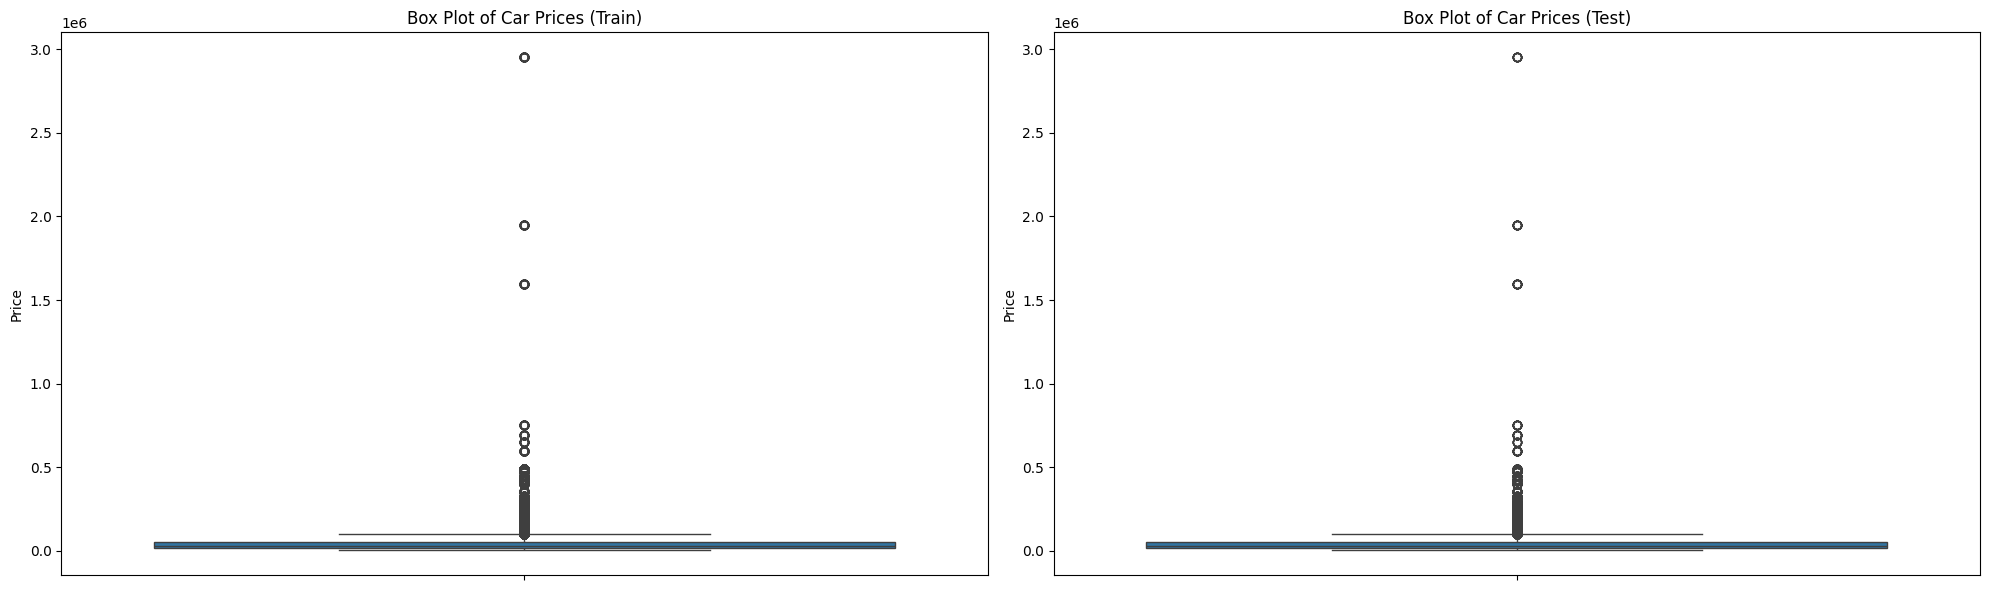

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(data=df_train, y='price', ax=axes[0])
axes[0].set_title('Box Plot of Car Prices (Train)')
axes[0].set_ylabel('Price')

sns.boxplot(data=df_test, y='price', ax=axes[1])
axes[1].set_title('Box Plot of Car Prices (Test)')
axes[1].set_ylabel('Price')

plt.tight_layout()
plt.show()

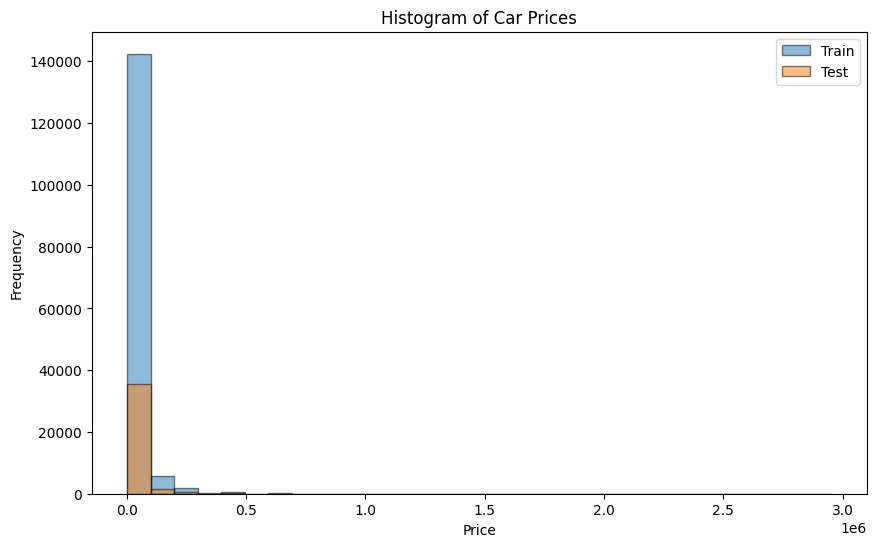

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

plt.hist(df_train['price'], bins=30, edgecolor='k')
axes[0].set_title('Histogram of Car Prices (Train)')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

plt.hist(df_test['price'], bins=30, edgecolor='k')
axes[1].set_title('Histogram of Car Prices (Test)')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [28]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_train['price'].quantile(0.25)
Q3 = df_train['price'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

# Define the lower and upper bounds for outliers with a less aggressive multiplier
lower_bound = 10000
upper_bound = 600000

# Filter out the outliers from the training data
df_train_no_outliers = df_train[(df_train['price'] >= lower_bound) & (df_train['price'] <= upper_bound)]

# Check the shape of the data before and after removing outliers
print(f'Original df_train shape: {df_train.shape}')
print(f'df_train shape after removing outliers: {df_train_no_outliers.shape}')



Q1: 17000.0, Q3: 49900.0, IQR: 32900.0
Original df_train shape: (150826, 57)
df_train shape after removing outliers: (134361, 57)


In [29]:
print(f'R2 Score before removing outliers: {round(score_after_change, 4)}')

# Re-train the model and check the R2 score
score_after_change = train_score_model(df_train_no_outliers, df_test)
print(f'R2 Score after removing outliers: {round(score_after_change, 4)}')

R2 Score before removing outliers: 0.105
R2 Score after removing outliers: 0.1042


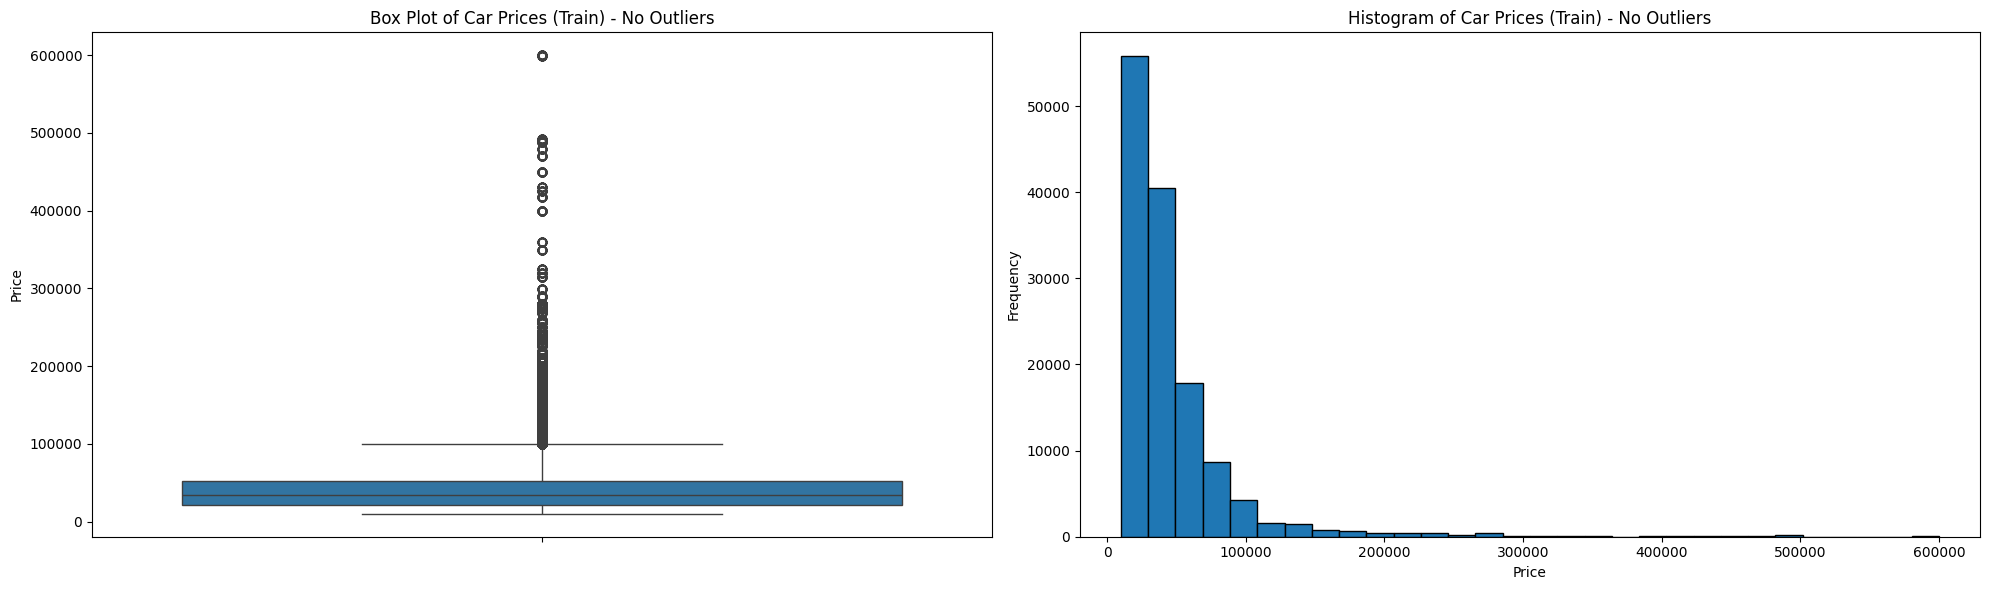

In [32]:








fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(data=df_train_no_outliers, y='price', ax=axes[0])
axes[0].set_title('Box Plot of Car Prices (Train) - No Outliers')
axes[0].set_ylabel('Price')

plt.hist(df_train_no_outliers['price'], bins=30, edgecolor='k')
axes[1].set_title('Histogram of Car Prices (Train) - No Outliers')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Checking the balance of the data - dividing the price into bins and seeing how many entries are there in each category after removing the outliers

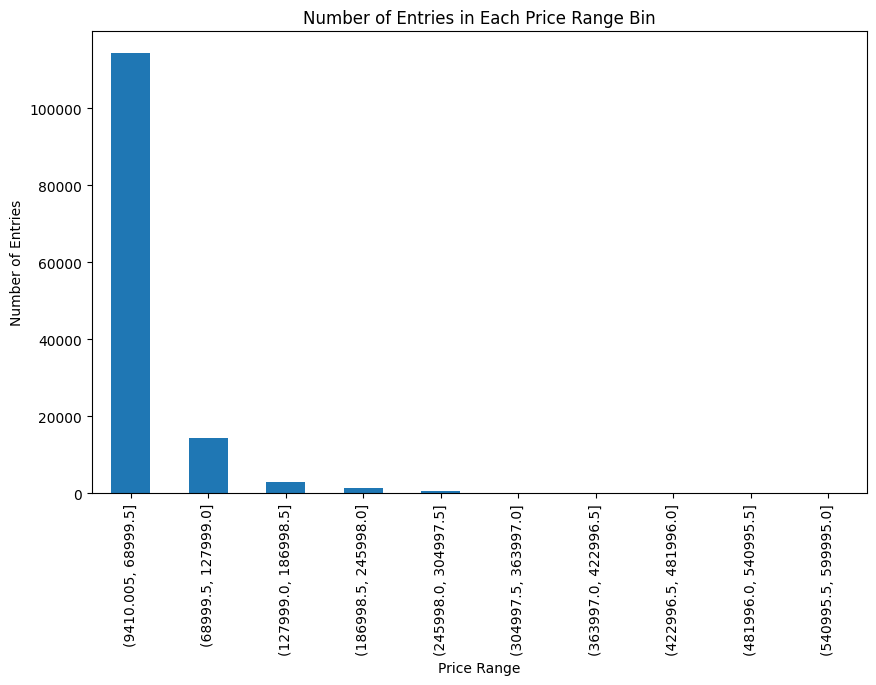

In [45]:






# Define the number of bins
num_bins = 10

df_train_bins = df_train_no_outliers.copy()

# Create bins for the price range
df_train_bins['price_bin'] = pd.cut(df_train_bins['price'], bins=num_bins)

# Count the number of entries in each bin
price_bin_counts = df_train_bins['price_bin'].value_counts().sort_index()

# Plot the number of entries in each bin
plt.figure(figsize=(10, 6))
price_bin_counts.plot(kind='bar')
plt.xlabel('Price Range')
plt.ylabel('Number of Entries')
plt.title('Number of Entries in Each Price Range Bin')
plt.show()

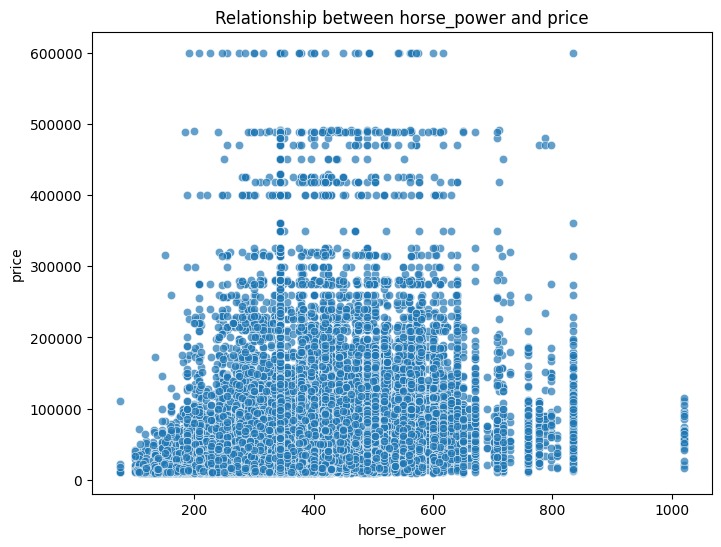

In [33]:
def plot_relationship(df, feature, target):
    """
    Plots the relationship between a feature and the target.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[feature], y=df[target], alpha=0.7)
    plt.title(f"Relationship between {feature} and {target}")
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

# Example usage:
plot_relationship(df_train_no_outliers, 'horse_power', 'price')

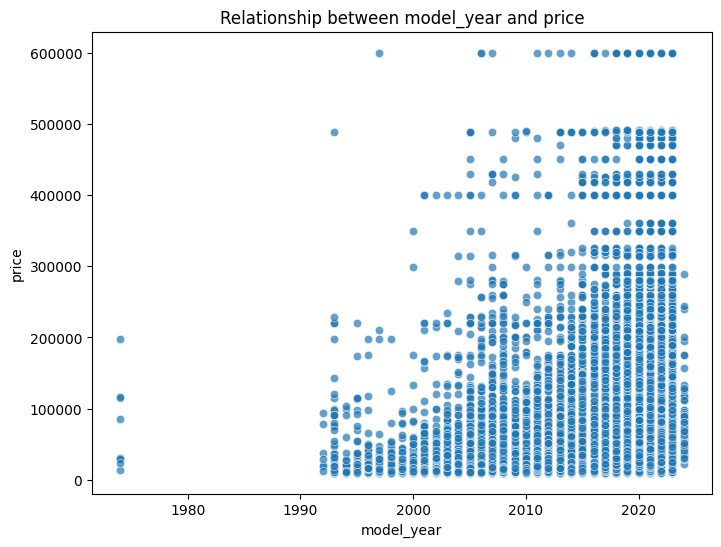

In [34]:
plot_relationship(df_train_no_outliers, 'model_year', 'price')

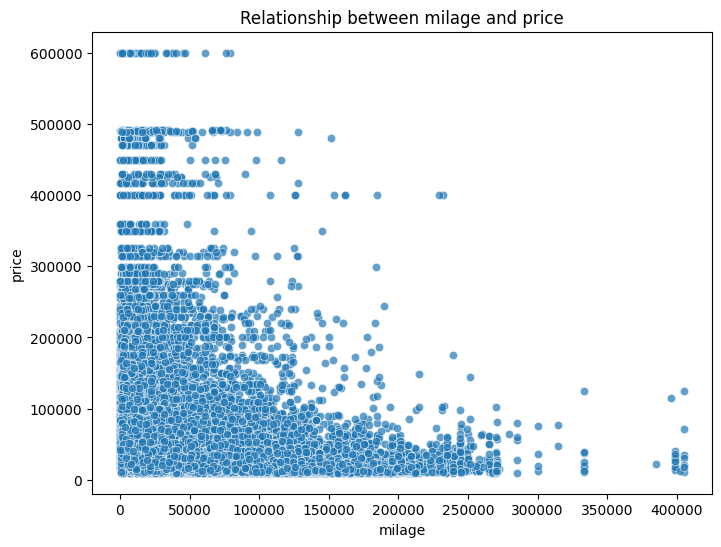

In [59]:





plot_relationship(df_train_no_outliers, 'milage', 'price')

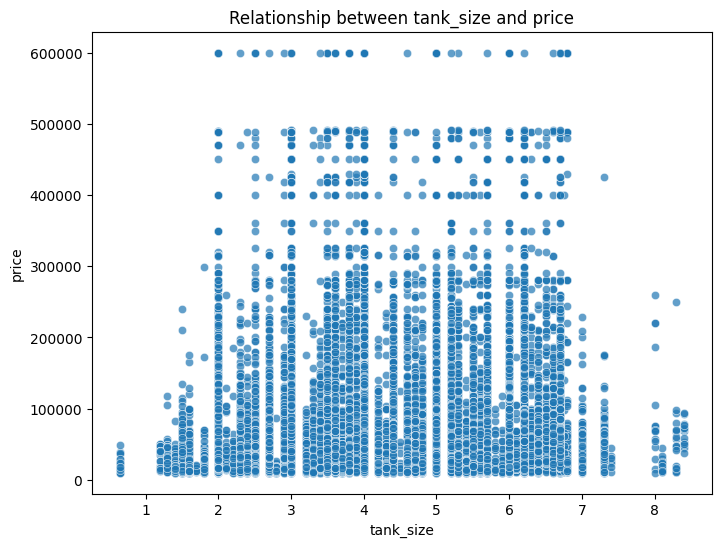

In [61]:





plot_relationship(df_train_no_outliers, 'tank_size', 'price')

In [35]:




def assess_feature_importance(df, feature, target):
    """
    Calculates correlation and fits a simple linear regression to assess feature importance.
    """
    # Correlation
    correlation = df[feature].corr(df[target])
    print(f"Correlation between {feature} and {target}: {correlation:.2f}")
    
    # Simple Linear Regression
    X = df[[feature]]
    y = df[target]
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    print(f"Simple Linear Regression MSE for {feature}: {mse:.2f}")
    
    return model

# Example usage:
model = assess_feature_importance(df_train_no_outliers, 'horse_power', 'price')


Correlation between horse_power and price: 0.30
Simple Linear Regression MSE for horse_power: 2000593710.71


In [36]:
model2 = assess_feature_importance(df_train_no_outliers, 'model_year', 'price')

Correlation between model_year and price: 0.33
Simple Linear Regression MSE for model_year: 1956307416.43


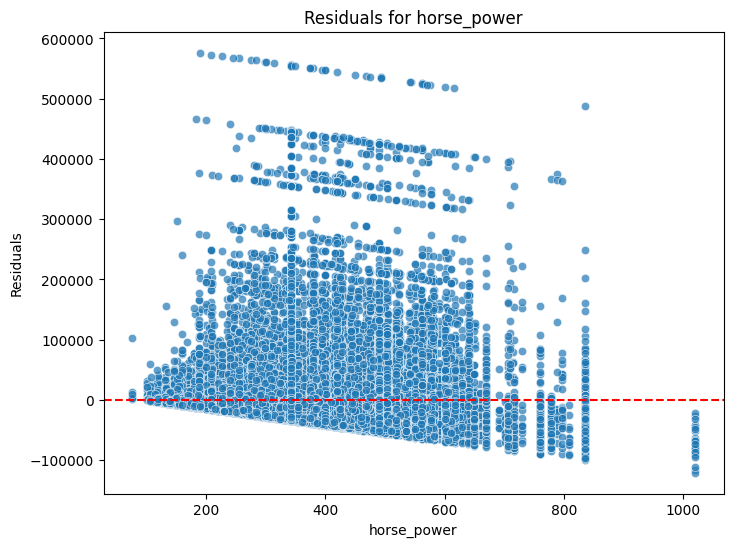

In [37]:
def plot_residuals(df, feature, target, model):
    """
    Plots residuals for a fitted model.
    """
    X = df[[feature]]
    y = df[target]
    residuals = y - model.predict(X)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[feature], y=residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals for {feature}")
    plt.xlabel(feature)
    plt.ylabel("Residuals")
    plt.show()

# Example usage:
plot_residuals(df_train_no_outliers, 'horse_power', 'price', model)


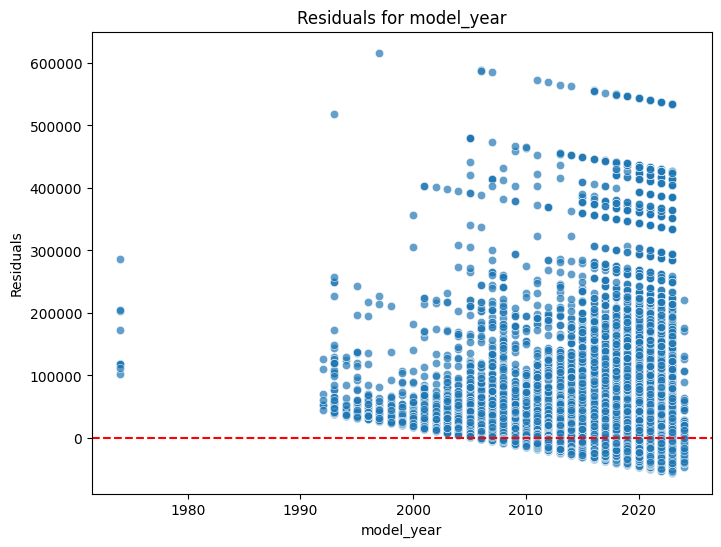

In [38]:
plot_residuals(df_train_no_outliers, 'model_year', 'price', model2)

In [64]:





def add_transformation_and_refit(df_train, df_test, feature, transform, score_after_change):
    """
    Applies a transformation to a feature, refits the model, and scores it.
    """
    # Apply transformation
    transformed_feature = f"{feature}_{transform}"
    if transform == "square":
        df_train[transformed_feature] = df_train[feature] ** 2
        df_test[transformed_feature] = df_test[feature] ** 2
    elif transform == "log":
        df_train[transformed_feature] = np.log1p(df_train[feature])
        df_test[transformed_feature] = np.log1p(df_test[feature])
    elif transform == "sqrt":
        df_train[transformed_feature] = np.sqrt(df_train[feature])
        df_test[transformed_feature] = np.sqrt(df_test[feature])
    elif transform == "exp":
        df_train[transformed_feature] = np.exp(df_train[feature])
        df_test[transformed_feature] = np.exp(df_test[feature])
    elif transform == "normalize":
        df_train[transformed_feature] = (df_train[feature] - df_train[feature].mean()) / df_train[feature].std()
        df_test[transformed_feature] = (df_test[feature] - df_train[feature].mean()) / df_train[feature].std()
    
    
    print(f'R2 Score before applying {transform} transformation to {feature}:: {round(score_after_change, 4)}')
        
    # Refit model
    score_after_change = train_score_model(df_train, df_test)  # Call your function
    print(f"R2 Score after applying {transform} transformation to {feature}: {score_after_change:.4f}")
    
    return df_train, df_test, score_after_change

In [53]:
# Example usage:
df_train_no_outliers, df_test, score_after_change = add_transformation_and_refit(df_train_no_outliers, df_test, 'horse_power', 'square', score_after_change)

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_34680\1000281572.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[transformed_feature] = df_train[feature] ** 2


R2 Score before applying square transformation to horse_power:: 0.1042
R2 Score after applying square transformation to horse_power: 0.1105


In [56]:





df_train_no_outliers, df_test, score_after_change = add_transformation_and_refit(df_train_no_outliers, df_test, 'model_year', 'square', score_after_change)

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_34680\1000281572.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[transformed_feature] = df_train[feature] ** 2


R2 Score before applying square transformation to model_year:: 0.1105
R2 Score after applying square transformation to model_year: 0.1113


In [66]:
df_train_no_outliers, df_test, score_after_change = add_transformation_and_refit(df_train_no_outliers, df_test, 'tank_size', 'sqrt', score_after_change)

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_34680\604377354.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[transformed_feature] = np.sqrt(df_train[feature])


R2 Score before applying sqrt transformation to tank_size:: 0.1113
R2 Score after applying sqrt transformation to tank_size: 0.1115


In [67]:
df_train_no_outliers, df_test, score_after_change = add_transformation_and_refit(df_train_no_outliers, df_test, 'tank_size', 'square', score_after_change)

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_34680\604377354.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[transformed_feature] = df_train[feature] ** 2


R2 Score before applying square transformation to tank_size:: 0.1115
R2 Score after applying square transformation to tank_size: 0.1116


In [43]:
from statsmodels.api import OLS, add_constant

In [57]:






def check_statistical_significance(df, features, target):
    """
    Checks statistical significance of features using OLS.
    """
    X = add_constant(df[features])
    y = df[target]
    
    model = OLS(y, X).fit()
    print(model.summary())
    
    return model

# Example usage:
model = check_statistical_significance(df_train_no_outliers, ['horse_power', 'horse_power_square'], 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     6745.
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:39:19   Log-Likelihood:            -1.6293e+06
No. Observations:              134361   AIC:                         3.259e+06
Df Residuals:                  134358   BIC:                         3.259e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.836e+04   1015

In [58]:
model2 = check_statistical_significance(df_train_no_outliers, ['model_year', 'model_year_square'], 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                 1.183e+04
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:39:41   Log-Likelihood:            -1.6248e+06
No. Observations:              134361   AIC:                         3.250e+06
Df Residuals:                  134358   BIC:                         3.250e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.018e+09   1.28e+0